In [73]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy.random as npr

from model import make_model, sample_model, plot_forestplots

sns.set_context('poster')
sns.set_style('white')
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Simulation Data

In systematically measuring genotype-phenotype data, how will the data be collected, stored and analyzed? Is a small laptop enough to model the fold change calculations locally? I explore this in the following notebook.

In [74]:
def make_simulated_data(n_reps_low, n_reps_high, n_genotypes):
    means = npr.randint(low=10, high=100, size=n_genotypes)
    means = means * (means > 0)  # negative activities are not captured
    sds = npr.random(size=n_genotypes) * 10
    num_measurements = npr.randint(low=n_reps_low, high=n_reps_high, size=n_genotypes)

    # Create simulated data.
    data = []
    indices = []

    for i in range(n_genotypes):
        n = num_measurements[i]
        mean = means[i]
        sd = sds[i]

        measurements = npr.normal(loc=mean, scale=sd, size=n)
        # print(measurements)
        measurements = measurements * (measurements > 0)
        # print(measurements)

        data.extend(measurements.tolist())
        indices.extend([i] * n)

    # Add baseline measurements (bl_measures)
    n_bl_measures = n_reps_high - 1
    bl_measures = npr.normal(loc=1.0, scale=0.1, size=n_bl_measures)
    bl_measures = bl_measures * (bl_measures > 0)
    data.extend(bl_measures)
    indices.extend([n_genotypes] * n_bl_measures)
    num_measurements = np.append(num_measurements, n_bl_measures)
    means = np.append(means, bl_measures.mean())
    sds = np.append(sds, bl_measures.std())

    # Add pos_ctrl measurements (pc_measures)
    n_pc_measures = n_reps_high - 1
    pc_measures = npr.normal(loc=20.0, scale=1, size=n_pc_measures)
    pc_measures = pc_measures * (pc_measures > 0)
    data.extend(pc_measures)
    indices.extend([n_genotypes + 1] * n_pc_measures)
    num_measurements = np.append(num_measurements, n_pc_measures)
    means = np.append(means, pc_measures.mean())
    sds = np.append(sds, pc_measures.std())

    # convert indices to a numpy array
    indices = np.array(indices)

    return data, indices, num_measurements, means, sds,

In [75]:
# Set n_genotypes > 1000 to obtain estimates of variance in error as a function of num_measurements
# Set n_genotypes < 15 to obtain diagnostic plots (traceplot) and comparison of modelled to actual.
# You've been forewarned - for the diagnostics and modelled, plotting with > 100 takes a while...
n_genotypes = 10

sim_data = make_simulated_data(n_genotypes=n_genotypes, n_reps_low=5, n_reps_high=6)
data, indices, num_measurements, means, sds = sim_data

In [76]:
# Compute the "actual" Z'-factor for the assay.
zp_det = 1 - (3 * sds[-2] + 3 * sds[-1]) / np.abs(means[-2] - means[-1])
zp_det

0.87699818083015457

In [77]:
model = make_model(n_genotypes, data, indices)

Applied log-transform to upper and added transformed upper_log_ to model.
Applied interval-transform to fold and added transformed fold_interval_ to model.
Applied log-transform to sigma and added transformed sigma_log_ to model.


In [78]:
%%time

trace = sample_model(model, n_genotypes)

Iteration 0 [0%]: ELBO = -210679.42
Iteration 20000 [10%]: Average ELBO = -44554.81
Iteration 40000 [20%]: Average ELBO = -220.32
Iteration 60000 [30%]: Average ELBO = -188.49
Iteration 80000 [40%]: Average ELBO = -185.93
Iteration 100000 [50%]: Average ELBO = -185.53
Iteration 120000 [60%]: Average ELBO = -185.49
Iteration 140000 [70%]: Average ELBO = -185.39
Iteration 160000 [80%]: Average ELBO = -185.36
Iteration 180000 [90%]: Average ELBO = -185.44
Finished [100%]: Average ELBO = -185.34
CPU times: user 26.3 s, sys: 176 ms, total: 26.5 s
Wall time: 27 s


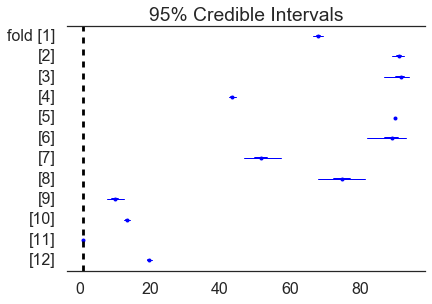

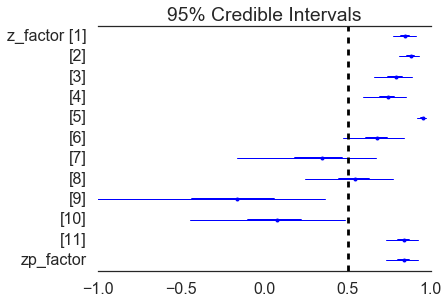

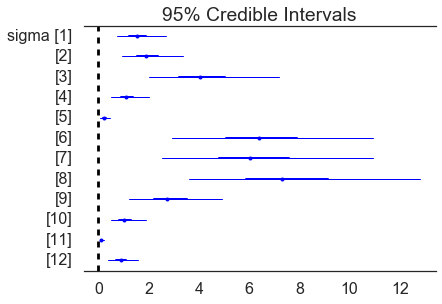

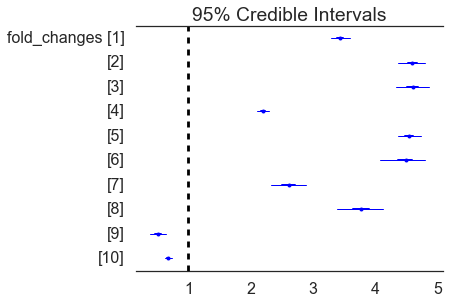

In [79]:
if n_genotypes <= 15:
    plot_forestplots(trace)

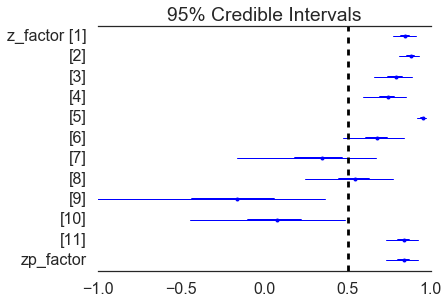

In [104]:
pm.forestplot(trace, varnames=['z_factor', 'zp_factor'], vline=0.5)
plt.xlim(-1, 1)
plt.savefig('../figures/z-factor_sim.pdf', bbox_inches='tight')

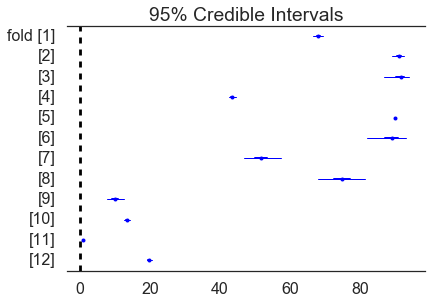

In [105]:
pm.forestplot(trace, varnames=['fold'])
plt.savefig('../figures/foldchange.pdf', bbox_inches='tight')

In [106]:
trace.varnames

['upper', 'fold', 'sigma', 'z_factor', 'zp_factor', 'fold_changes']

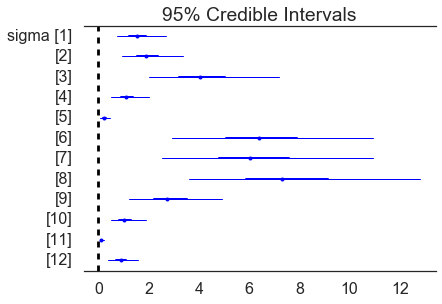

In [107]:
pm.forestplot(trace, varnames=['sigma'])
plt.savefig('../figures/sigma.pdf', bbox_inches='tight')

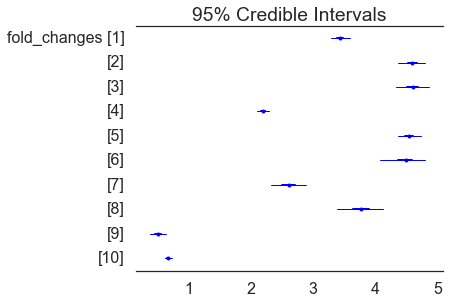

In [108]:
pm.forestplot(trace, varnames=['fold_changes'])
plt.savefig('../figures/fold_changes.pdf', bbox_inches='tight')

In [85]:
if n_genotypes <= 15:
    pm.summary(trace)


upper:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  94.684           0.107            0.002            [94.487, 94.902]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  94.481         94.607         94.684         94.758         94.898


fold:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  68.033           0.706            0.016            [66.666, 69.439]
  90.980           0.937            0.023            [89.054, 92.573]
  91.038           2.150            0.048            [86.667, 93.919]
  43.467           0.500            0.012            [42.523, 44.444]
  90.066           0.153            0.003            [89.786, 90.376]
  88.503           3.134            0.077        

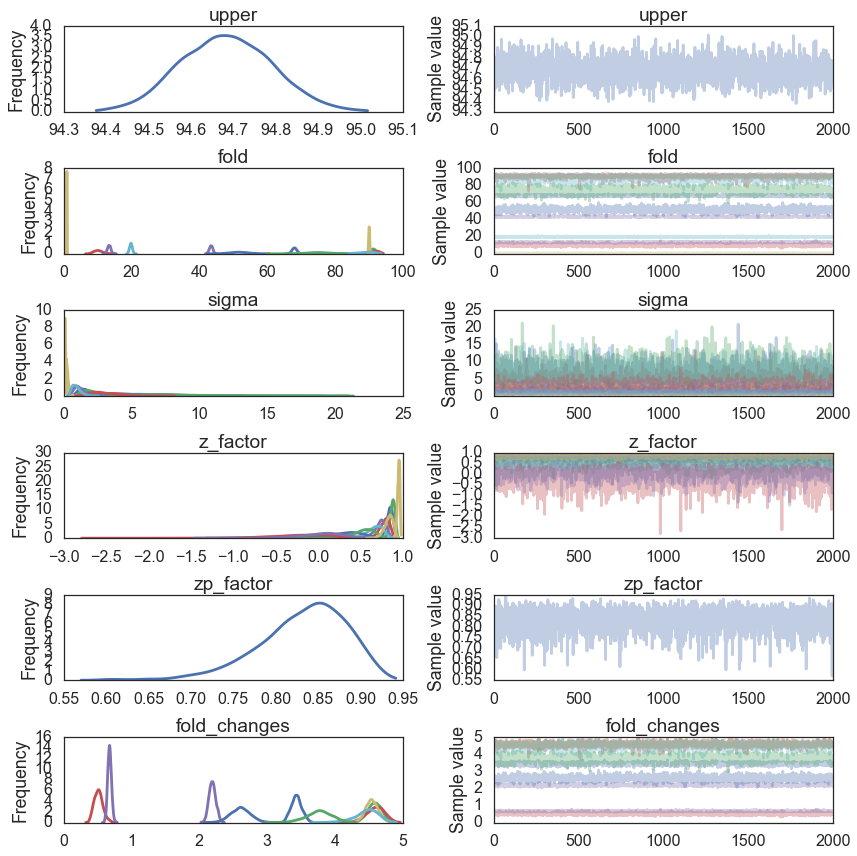

In [86]:
if n_genotypes <= 15:
    pm.traceplot(trace)

# Error in Estimated Mean

What is the error in estimated mean as a function of the number of measurements?

In [87]:
num_measurements

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5])

In [88]:
trace['fold'].mean(axis=0) - means

array([-0.96721422, -0.01972597,  0.03795999, -1.53290356,  0.06597311,
       -3.49671172, -2.30280451,  1.66551424,  0.19818178, -0.57103842,
       -0.00577401, -0.03818696])

In [89]:
import pandas as pd
errors_df = pd.DataFrame([num_measurements, (trace['fold'].mean(axis=0) - means)]).T
errors_df.columns = ['num_measurements', 'error_means']
errors_df.head()

,num_measurements,error_means
0,5.0,-0.967214
1,5.0,-0.019726
2,5.0,0.037960
3,5.0,-1.532904
4,5.0,0.065973


In [90]:
if n_genotypes >= 500:
    sns.boxplot(data=errors_df, x='num_measurements', y='error_means')
    ax = plt.gca()
    labels = ax.get_xticklabels()
    # plt.xticks(x=sorted(list(set(errors_df['num_measurements']))), )
    plt.xticks(rotation=90)
    plt.ylabel('Error in Fold Change')
    plt.xlabel('Num. Measurements')
    plt.savefig('../figures/error-means.pdf', bbox_inches='tight')
    
    errors_df.groupby('num_measurements').var().plot(legend=False)
    plt.ylabel('Variance in Error')
    plt.xlabel('Num. Measurements')
    plt.savefig('../figures/var-error-means.pdf', bbox_inches='tight')

In [91]:
(trace['fold'].mean(axis=0) - means).mean()

-0.58056085426249626

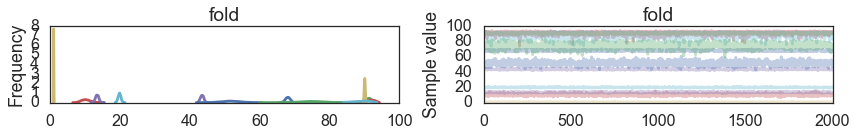

In [92]:
if n_genotypes <= 15:
    plt.figure()
    pm.traceplot(trace, varnames=['fold'])
    plt.figure()

# Compare modelled to actual

In [93]:
trace['fold'].mean(axis=0)

array([ 68.03278578,  90.98027403,  91.03795999,  43.46709644,
        90.06597311,  88.50328828,  51.69719549,  74.66551424,
        10.19818178,  13.42896158,   0.97741731,  19.83294748])

In [94]:
trace['fold'].mean(axis=0).shape

(12,)

In [95]:
np.arange(1, n_genotypes+3).shape

(12,)

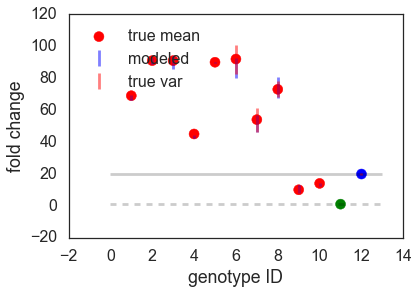

In [96]:
if n_genotypes <= 15:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    lower = trace['fold'].mean(axis=0) - np.percentile(trace['fold'], 2.5, axis=0)
    upper = np.percentile(trace['fold'], 97.5, axis=0) - trace['fold'].mean(axis=0)
    yerr_pos = [lower, upper]
    ax.errorbar(x=np.arange(1, n_genotypes+3), y=trace['fold'].mean(axis=0), 
                # y-error bars
                yerr=yerr_pos,
                # styling
                color='blue', ls='none', alpha=0.5, label='modeled',)
    ax.scatter(x=np.arange(1, n_genotypes+3), y=means, 
               # styling
               color=['red'] * (n_genotypes) + ['green'] + ['blue'], marker='o', s=100, label='true mean',)
    ax.errorbar(x=np.arange(1, n_genotypes+3), y=means,
               yerr=sds,
               color='red', ls='none', alpha=0.5, label='true var')
    ax.legend(loc='upper left', frameon=False)
    ax.hlines(xmin=0, xmax=n_genotypes+3, y=trace['fold'].mean(axis=0)[-2], linestyles='--', alpha=0.2)
    ax.hlines(xmin=0, xmax=n_genotypes+3, y=trace['fold'].mean(axis=0)[-1], alpha=0.2)
    ax.set_xlabel('genotype ID')
    ax.set_ylabel('fold change')
    # ax.set_xlim(, n_genotypes+2)

just for checking the above plot...


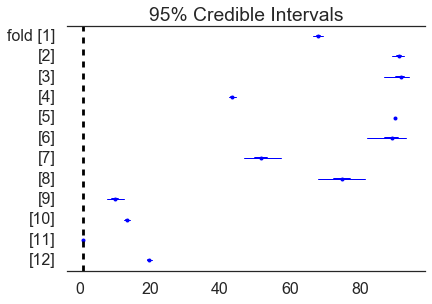

In [97]:
if n_genotypes <= 15:
    fig = plt.figure()
    pm.forestplot(trace, vline=1, varnames=['fold'])
print('just for checking the above plot...')

How often is the true mean inside the 95% HPD?

In [98]:
lower, upper = np.percentile(trace['fold'], [2.5, 97.5], axis=0)
lower, upper

(array([ 66.61506672,  88.82107654,  85.68841765,  42.50329954,
         89.77676767,  80.31691434,  46.47258623,  67.3766406 ,
          7.97181545,  12.50006431,   0.87791124,  19.03858363]),
 array([ 69.40393391,  92.49596881,  93.61746829,  44.43357664,
         90.36686159,  92.54938933,  57.09007539,  80.73255744,
         12.97372618,  14.38604402,   1.07858335,  20.66534654]))

In [99]:
means

array([ 69.        ,  91.        ,  91.        ,  45.        ,
        90.        ,  92.        ,  54.        ,  73.        ,
        10.        ,  14.        ,   0.98319132,  19.87113444])

In [100]:
# Here is the fraction of means that have been correctly included within the 95% HPD.
sum((means > lower) *  (means < upper)) / len(means)

0.91666666666666663

How many Z-factors are have their 95% HPD above the 0.5 line?

In [101]:
z_fact = trace['z_factor']
z_fact_mean = trace['z_factor'].mean(axis=0)
z_fact_lower = np.percentile(z_fact, 2.5, axis=0)
false_hits = (z_fact_lower < 0.5) * (z_fact_mean > 0.5)
true_hits = (z_fact_lower > 0.5) * (z_fact_mean > 0.5)

false_hit_rate = false_hits.sum() / len(false_hits)
false_hit_rate

0.18181818181818182

In [102]:
false_hit_prob = false_hits.sum() / (true_hits.sum() + false_hits.sum())
false_hit_prob

0.25

In [103]:
true_hit_prob = true_hits.sum() / (true_hits.sum() + false_hits.sum())
true_hit_prob

0.75